In [1]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import scvi

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"

In [2]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
SLN_206_adata = sc.read(f"{save_path}/spleen_lymph_206.h5ad")
SLN_111_adata = sc.read(f"{save_path}/spleen_lymph_111.h5ad")

In [3]:
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in SLN_111_adata.uns["protein_names"]]
)
SLN_111_adata.obsm["protein_expression"] = SLN_111_adata.obsm["protein_expression"][
    :, keep_pro_111
]
SLN_111_adata.uns["protein_names"] = SLN_111_adata.uns["protein_names"][keep_pro_111]

In [4]:
keep_pro_206 = np.array(
    [not p.startswith("HTO") for p in SLN_206_adata.uns["protein_names"]]
)
SLN_206_adata.obsm["protein_expression"] = SLN_206_adata.obsm["protein_expression"][
    :, keep_pro_206
]
SLN_206_adata.uns["protein_names"] = SLN_206_adata.uns["protein_names"][keep_pro_206]

In [29]:
rna_data_111 = ad.AnnData(
    X=SLN_111_adata.X,
    obs=SLN_111_adata.obs,
    var=pd.DataFrame(index=SLN_111_adata.var.index),
)
rna_data_111.obs['n_counts']  = rna_data_111.X.sum(axis=1)
rna_data_111.obs['panel']  = '111'
rna_data_111.obs_names = 'p111_'+rna_data_111.obs_names

In [30]:
rna_data_206 = ad.AnnData(
    X=SLN_206_adata.X,
    obs=SLN_206_adata.obs,
    var=pd.DataFrame(index=SLN_206_adata.var.index),
)
rna_data_206.obs['n_counts']  = rna_data_206.X.sum(axis=1)
rna_data_206.obs['panel']  = '206'
rna_data_206.obs_names = 'p206_'+rna_data_206.obs_names

In [82]:
protein_data_111 = ad.AnnData(
    X=np.array(SLN_111_adata.obsm["protein_expression"]),
    obs=SLN_111_adata.obs.copy(),
    var=SLN_111_adata.uns["protein_names"].copy()
)
protein_data_111.var_names = SLN_111_adata.uns["protein_names"]
protein_data_111.var = protein_data_111.var.drop(columns=0)
protein_data_111.obs['n_counts']  = protein_data_111.X.sum(axis=1)
protein_data_111.obs['panel']  = '111'
protein_data_111.obs_names = 'p111_'+protein_data_111.obs_names

In [83]:
protein_data_206 = ad.AnnData(
    X=np.array(SLN_206_adata.obsm["protein_expression"]),
    obs=SLN_206_adata.obs.copy(),
    var=SLN_206_adata.uns["protein_names"].copy()
)
protein_data_206.var_names = SLN_206_adata.uns["protein_names"]
protein_data_206.var = protein_data_206.var.drop(columns=0)
protein_data_206.obs['n_counts']  = protein_data_206.X.sum(axis=1)
protein_data_206.obs['panel']  = '206'
protein_data_206.obs_names = 'p206_'+protein_data_206.obs_names

In [33]:
# merge the rna adata of the two datasets
rna_adata_pool = ad.concat([rna_data_111, rna_data_206], join="outer", axis=0)

In [34]:
protein_adata_pool = ad.concat([protein_data_111, protein_data_206], join="outer", axis=0)

In [85]:
protein_adata_intersect = ad.concat([protein_data_111, protein_data_206], join="inner", axis=0)
protein_adata_intersect 

AnnData object with n_obs × n_vars = 32648 × 110
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'

In [35]:
rna_adata_pool

AnnData object with n_obs × n_vars = 32648 × 13553
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'

# Preprocess

In [86]:
mdata = mu.MuData({
    "rna": rna_adata_pool,
    "protein": protein_adata_intersect,
})

In [37]:
rna_adata_pool.var['mt'] = rna_adata_pool.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna_adata_pool, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

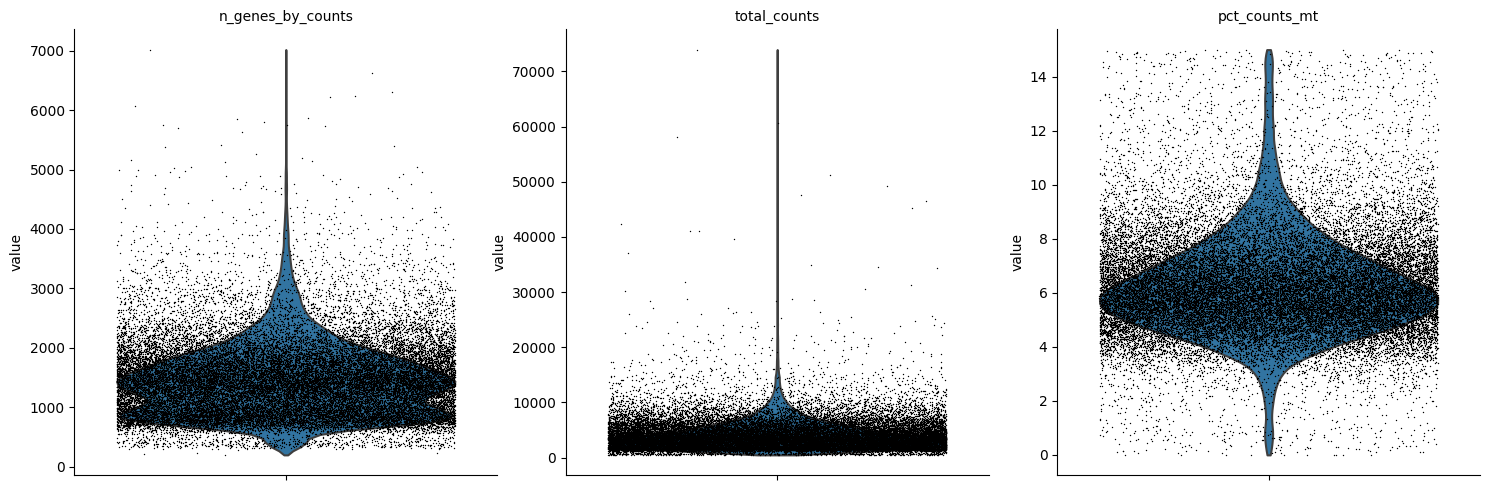

In [38]:
sc.pl.violin(rna_adata_pool, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [39]:
rna_adata_pool.layers["counts"] = rna_adata_pool.X.copy()

In [40]:
sc.pp.normalize_total(rna_adata_pool, target_sum=1e4)
sc.pp.log1p(rna_adata_pool)
rna_adata_pool.obs_names_make_unique()

In [41]:
sc.pp.highly_variable_genes(
    rna_adata_pool,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch_indices",
    layer="counts",
)

In [42]:
sc.tl.pca(rna_adata_pool, svd_solver='arpack')
sc.pp.neighbors(rna_adata_pool, n_neighbors=10, n_pcs=20)
sc.tl.leiden(rna_adata_pool, resolution=.75)
sc.tl.umap(rna_adata_pool, spread=1., min_dist=.5, random_state=42)

In [43]:
rna_adata_pool.write_h5ad(f"{save_path}/rna_pool.h5ad")

In [44]:
protein_adata_pool.layers["counts"] = protein_adata_pool.X.copy()
# sc.pp.normalize_total(protein_adata_pool, target_sum=1e4)
# sc.pp.log1p(protein_adata_pool)

In [45]:
protein_adata_pool.layers["counts"] = np.nan_to_num(protein_adata_pool.layers["counts"], nan=0.0)
protein_adata_pool.X = protein_adata_pool.layers["counts"].copy()
sc.pp.normalize_total(protein_adata_pool, target_sum=1e4)
sc.pp.log1p(protein_adata_pool)

In [46]:
protein_adata_pool.write_h5ad(f"{save_path}/protein_pool.h5ad")

In [87]:
# protein_adata_intersect.layers["counts"] = np.nan_to_num(protein_adata_intersect.layers["counts"], nan=0.0)
protein_adata_intersect.X = np.nan_to_num(protein_adata_intersect.X, nan=0.0)
sc.pp.normalize_total(protein_adata_intersect, target_sum=1e4)
sc.pp.log1p(protein_adata_intersect)

In [88]:
protein_adata_intersect.write(f"{save_path}/scCITE_intersect_protein.h5ad")
mdata.write_h5mu(f"{save_path}/scCITE_intersect.h5mu")

In [53]:
mdata.write_h5mu(f"{save_path}/scCITE_combine.h5mu")

# GraphCrossAttn

In [1]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import torch
from dataset import GeneVocab
from dataset import SinglecellData
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
rna_adata_pool = ad.read_h5ad(f"{save_path}/rna_pool.h5ad")
# protein_adata_pool = ad.read_h5ad(f"{save_path}/protein_pool.h5ad")
protein_adata_intersect = ad.read_h5ad(f"{save_path}/scCITE_intersect_protein.h5ad")

## With highly variable

In [3]:
rna_adata_pool

AnnData object with n_obs × n_vars = 32648 × 13553
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
rna_adata_pool_subset = rna_adata_pool[:, rna_adata_pool.var["highly_variable"]]
rna_adata_pool_subset = rna_adata_pool_subset[:, 
        rna_adata_pool_subset.var.sort_values(by="highly_variable_rank").index]

In [5]:
highly_variable_names = rna_adata_pool_subset.var_names.to_list()
# df = pd.DataFrame(highly_variable_names)
# df.to_csv(f"{save_path}/scCITE_hvg.csv", index=False)

In [6]:
model_choice = "Graph Cross Attention"

rna_input_dim = rna_adata_pool_subset.X.shape[1]
prot_input_dim = protein_adata_intersect.X.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

adj_mtx = rna_adata_pool_subset.obsp['connectivities'].toarray()
edge_index = adj_mtx.nonzero()
edge_index = np.array(edge_index)
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous().to(device)
concat_data = np.concatenate((rna_adata_pool_subset.X, protein_adata_intersect.X), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

num_splits = 2
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData)

In [ ]:
import importlib
import sys

importlib.reload(sys.modules['train'])

<module 'train' from '/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/train.py'>

In [7]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=0.75,
    permute=False,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()

Epoch 1/20 train_loss: 1.48649 val_loss: 18.69630
Epoch 2/20 train_loss: 1.12035 val_loss: 13.70648
Epoch 3/20 train_loss: 1.06248 val_loss: 13.03054
Epoch 4/20 train_loss: 1.04691 val_loss: 12.58910
Epoch 5/20 train_loss: 0.97806 val_loss: 11.93984
Epoch 6/20 train_loss: 0.92849 val_loss: 11.32541
Epoch 7/20 train_loss: 0.89909 val_loss: 10.89892
Epoch 8/20 train_loss: 0.86064 val_loss: 10.61346
Epoch 9/20 train_loss: 0.84023 val_loss: 10.38576
Epoch 10/20 train_loss: 0.82069 val_loss: 10.19826
Epoch 11/20 train_loss: 0.80130 val_loss: 10.01235
Epoch 12/20 train_loss: 0.79155 val_loss: 9.86280
Epoch 13/20 train_loss: 0.77883 val_loss: 9.71202
Epoch 14/20 train_loss: 0.77637 val_loss: 9.58386
Epoch 15/20 train_loss: 0.76366 val_loss: 9.46750
Epoch 16/20 train_loss: 0.75338 val_loss: 9.41661
Epoch 17/20 train_loss: 0.74863 val_loss: 9.30816
Epoch 18/20 train_loss: 0.74262 val_loss: 9.23904
Epoch 19/20 train_loss: 0.74048 val_loss: 9.13916
Epoch 20/20 train_loss: 0.72887 val_loss: 9.0863

In [94]:
# save the best model parameters
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/scCITE_intersect_hvg.pt")

In [9]:
model = trainer.best_model

In [10]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [97]:
# df.DataFrame(mdata.mod['rna'].var[mdata.mod['rna'].var["highly_variable"]].index).to_csv("../data/scCITE_combined_hvg_list.csv")

In [98]:
np.save("../data/GraphCrossRNArecon_intersect_hvg_SLN_scCITE.npy", rna_recon)
np.save("../data/GraphCrossPorteinrecon_intersect_hvg_SLN_scCITE.npy", prot_recon)

In [99]:
np.save("../data/GraphCrossEmbedding_intersect_hvg_SLN_scCITE.npy", embedding)

In [14]:
train_losses

[[tensor(1.4865, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(1.1204, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(1.0625, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(1.0469, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.9781, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.9285, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.8991, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.8606, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.8402, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.8207, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.8013, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.7916, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.7788, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.7764, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.7637, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.7534, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.7486, device='cuda:0', grad_fn=<AddBackward0>

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

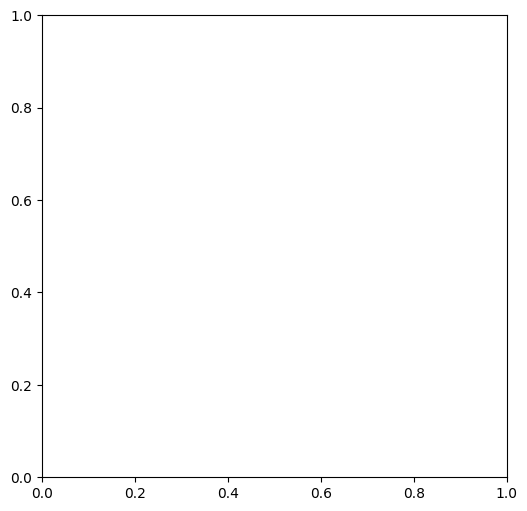

In [11]:
# plot the training and validation loss
plt.figure(figsize=(6,6))
plt.plot(train_losses[0], label="train")
plt.plot(val_losses[0], label="validation")
plt.title("Intersect_HVG subset loss decline", fontsize=24)
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size': 16, 'weight': 'normal'}, handlelength=3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig("scCITE_intersect_training_hvg_loss.png")

In [101]:
mdata = mu.MuData({
    "rna": rna_adata_pool,
    "protein": protein_adata_intersect,
})
mdata

MuData object with n_obs × n_vars = 32648 × 13658
  2 modalities
    rna:	32648 x 13548
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'

## With whole transcriptomics

In [3]:
mdata = mu.read_h5mu(f"{save_path}scCITE_combine.h5mu")
mdata

MuData object with n_obs × n_vars = 32648 × 13760
  2 modalities
    rna:	32648 x 13553
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 207
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'
      layers:	'counts'

In [4]:
mdata.update()

In [5]:
gene_dict = {
    "Atn1-1": "Atn1",
    "Dancr-1": "Dancr",
    "Gbp6-1": "Gbp6",
    "Hist2h2bb-1": "Hist2h2bb",
    "Itgam-1": "Itgam",
    "Pcdhga8-1": "Pcdhga8",
    "Smim20-1": "Smim20",
    "U2af1l4-1": "U2af1l4",
}

In [6]:
# replace var_names using gene_dict
for k, v in gene_dict.items():
    mdata.mod['rna'].var_names = mdata.mod['rna'].var_names.str.replace(k, v)

In [7]:
# find the repeated gene names and only keep the first one
gene_names = mdata.mod['rna'].var_names
gene_names = pd.Series(gene_names)
# gene_names[gene_names.duplicated(keep=False)]
gene_names = gene_names[~gene_names.duplicated(keep='first')]
gene_names

0                Mrpl15
1                Lypla1
2                 Tcea1
3               Atp6v1h
4                Rb1cc1
              ...      
13548        AC125149.3
13549        AC168977.1
13550              PISD
13551             DHRSX
13552    CAAA01147332.1
Name: index, Length: 13548, dtype: object

In [8]:
mdata.mod["rna"] = mdata.mod['rna'][:, gene_names.index]
mdata

MuData object with n_obs × n_vars = 32648 × 13760
  2 modalities
    rna:	32648 x 13548
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 207
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'
      layers:	'counts'

In [11]:
gtf_path = "/DATA/User/wuxinchao/st_cite_data/ref/Mus_musculus.GRCm38.84.gtf"
geneVocab = GeneVocab(mdata.mod['rna'])
geneVocab.sort_by_genomic_position(gtf_path)
sc_rna_data = geneVocab.align_features(mdata.mod['rna'])
sc_prot_data = mdata.mod['protein'][mdata.mod['rna'].obs_names]
sc_rna_data.obsp = mdata.mod['rna'].obsp
# sc_prot_data.var_names = sc_prot_data.var_names.str.split("_").str[-2]

In [12]:
model_choice = "Graph Cross Attention"

rna_input_dim = sc_rna_data.X.shape[1]
prot_input_dim = sc_prot_data.X.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

scData = SinglecellData(mdata, geneVocab)

num_splits = 2
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData.data)

In [13]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=20,
    mask_ratio=mask_ratio,
    permute=permute,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()

Epoch 1/20 train_loss: 146.27597 val_loss: 24.06301
Epoch 2/20 train_loss: 53.28050 val_loss: 12.31422
Epoch 3/20 train_loss: 31.94877 val_loss: 9.76670
Epoch 4/20 train_loss: 28.22417 val_loss: 9.54354
Epoch 5/20 train_loss: 27.86188 val_loss: 9.51136
Epoch 6/20 train_loss: 27.74926 val_loss: 9.46362
Epoch 7/20 train_loss: 27.54523 val_loss: 9.35885
Epoch 8/20 train_loss: 27.19448 val_loss: 9.23387
Epoch 9/20 train_loss: 26.56117 val_loss: 8.97669
Epoch 10/20 train_loss: 25.77815 val_loss: 8.75822
Epoch 11/20 train_loss: 25.16904 val_loss: 8.57291
Epoch 12/20 train_loss: 24.70059 val_loss: 8.45274
Epoch 13/20 train_loss: 24.32517 val_loss: 8.37154
Epoch 14/20 train_loss: 24.11567 val_loss: 8.31517
Epoch 15/20 train_loss: 23.90126 val_loss: 8.26958
Epoch 16/20 train_loss: 23.76920 val_loss: 8.21635
Epoch 17/20 train_loss: 23.62305 val_loss: 8.15923
Epoch 18/20 train_loss: 23.50937 val_loss: 8.13411
Epoch 19/20 train_loss: 23.42136 val_loss: 8.11693
Epoch 20/20 train_loss: 23.29162 val_

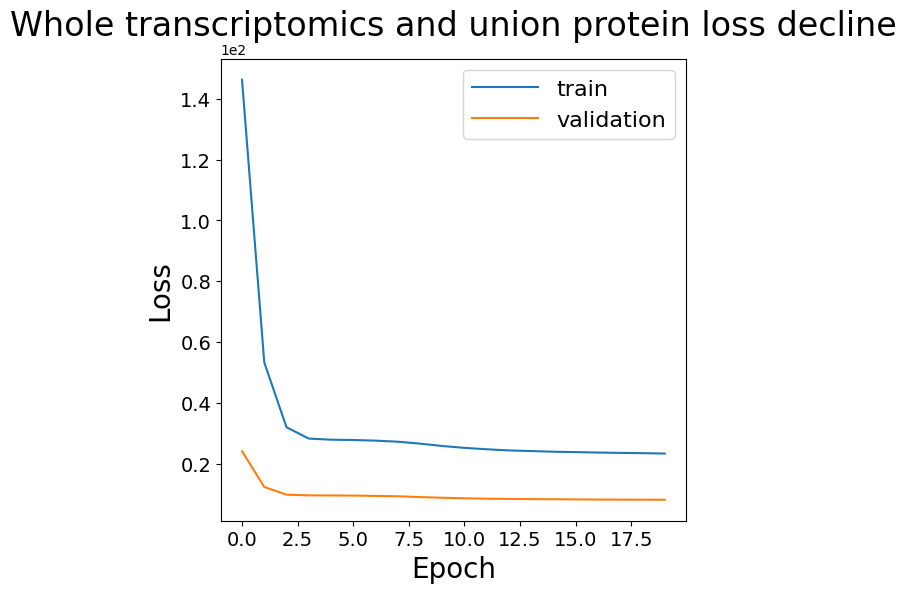

In [14]:
# plot the training and validation loss
plt.figure(figsize=(6,6))
plt.plot(train_losses[0], label="train")
plt.plot(val_losses[0], label="validation")
plt.title("Whole transcriptomics and union protein loss decline", fontsize=24)
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size': 16, 'weight': 'normal'}, handlelength=3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig("scCITE_whole_trans_training_union_loss.png")

In [15]:
# save the best model parameters
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/scCITE_seq_whole_union.pt")

In [16]:
model = trainer.best_model

In [17]:
adj_mtx = rna_adata_pool_subset.obsp['connectivities'].toarray()
edge_index = adj_mtx.nonzero()
edge_index = np.array(edge_index)
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous().to(device)
concat_data = np.concatenate((sc_rna_data.X, sc_prot_data.X), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

NameError: name 'rna_adata_pool_subset' is not defined

In [ ]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [122]:
from scipy.sparse import csr_matrix, save_npz

rna_recon = csr_matrix(rna_recon)
prot_recon = csr_matrix(prot_recon)
save_npz("../data/GraphCrossRNArecon_combined_whole_trans_intersect_SLN_scCITE.npz", rna_recon)
save_npz("../data/GraphCrossPorteinrecon_combined_whole_trans_intersect_SLN_scCITE.npz", prot_recon)
# np.save("../data/GraphCrossRNArecon_combined_intersect_SLN_scCITE.npy", rna_recon)
# np.save("../data/GraphCrossPorteinrecon_combined_intersect_SLN_scCITE.npy", prot_recon)

In [ ]:
np.save("../data/GraphCrossEmbedding_combined_whole_trans_union_SLN_scCITE.npy", embedding)

In [125]:
mdata

MuData object with n_obs × n_vars = 32648 × 13658
  2 modalities
    rna:	32648 x 13548
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'

# spatial

## spCITE spleen mouse

In [1]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import scvi

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
mdata = mu.read_h5mu("/home/wuxinchao/data/st_cite_data/spatial_cite_data/mouse_spleen_spCITE.h5mu")

In [3]:
rna_adata = mdata.mod['rna']
prot_adata = mdata.mod["prot"]

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


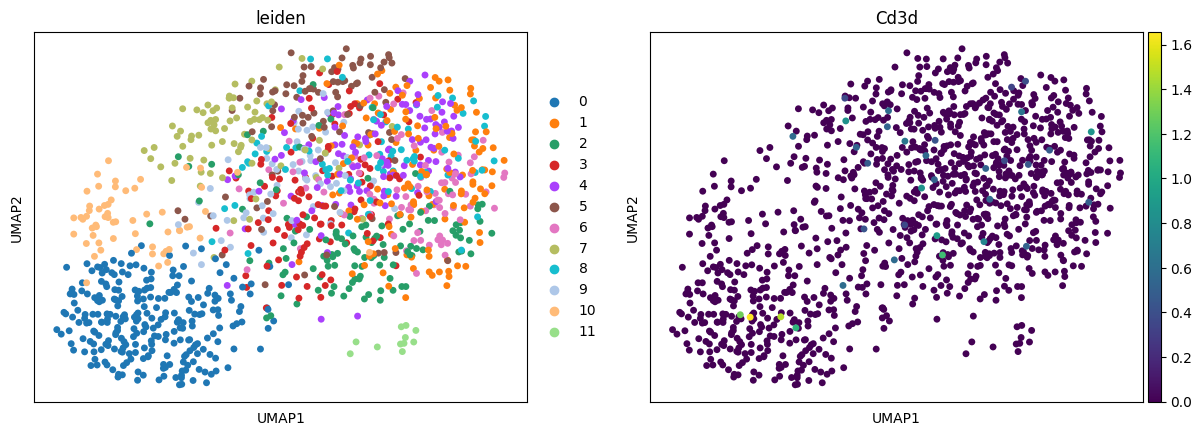

In [149]:
rna_adata.layers["counts"] = rna_adata.X.copy()
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
rna_adata.obs_names_make_unique()

sc.pp.highly_variable_genes(
    rna_adata,
    n_top_genes=4000,
    flavor="seurat_v3",
    # batch_key="batch",
    layer="counts",
)
rna_adata.raw = rna_adata
sc.pp.scale(rna_adata, max_value=10)
sc.tl.pca(rna_adata, svd_solver='arpack')
sc.pp.neighbors(rna_adata, n_neighbors=10, n_pcs=50)

sc.tl.leiden(rna_adata, resolution=1)
sc.tl.umap(rna_adata, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(rna_adata, color=['leiden','Cd3d'])

In [147]:
# int(rna_adata.obs["x"]), int(rna_adata.obs["y"])
rna_adata.obs["x"] = rna_adata.obs["x"].astype(float)
rna_adata.obs["y"] = rna_adata.obs["y"].astype(float)
rna_adata.obsm["spatial"] = rna_adata.obs[["x", "y"]].values

In [154]:
prot_adata.obs[["x", "y"]] = rna_adata.obs[["x", "y"]]

In [155]:
prot_adata.obs["x"] = prot_adata.obs["x"].astype(float)
prot_adata.obs["y"] = prot_adata.obs["y"].astype(float)
prot_adata.obsm["spatial"] = prot_adata.obs[["x", "y"]].values

In [283]:
mdata.write("/home/wuxinchao/data/st_cite_data/spatial_cite_data/mouse_spleen_spCITE.h5mu")

In [7]:
highly_variable = pd.read_csv(f"{save_path}/scCITE_hvg.csv")

In [8]:
# rna_adata[:,highly_variable.iloc[:,0]]
rna_adata_hvg_transfer = rna_adata[:, rna_adata.var_names.isin(highly_variable.iloc[:,0].to_list())]
rna_adata_hvg_transfer

View of AnnData object with n_obs × n_vars = 1222 × 3210
    obs: 'n_genes', 'x', 'y', 'leiden'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_proximity'

In [9]:
# new_exp = np.zeros_like((rna_adata_hvg_transfer.shape[0], len(highly_variable)-1))
highly_variable.index = highly_variable.iloc[:,0]
highly_variable = highly_variable.T
highly_variable = highly_variable.drop('0')

In [10]:
for i, gene_name in enumerate(rna_adata_hvg_transfer.var_names):
    highly_variable[gene_name] = rna_adata_hvg_transfer.X[:,i]
# highly_variable["Akap12"] = rna_adata_hvg_transfer.X[:,2]

In [11]:
highly_variable = highly_variable.fillna(0)

In [12]:
prot_adata.layers["counts"] = prot_adata.X.copy()

In [13]:
prot_adata.X = prot_adata.layers["counts"].copy()
sc.pp.normalize_total(prot_adata, target_sum=1e4)
sc.pp.log1p(prot_adata)

In [14]:
# ''.join(filter(str.isalnum, prot_adata.var_names[prot_adata.var_names.str.contains("CD")].to_list()[0].lower()))
list1 = [i[:-1] for i in protein_adata_intersect.var_names.str.replace("ADT_", "").str.split("_")]
list2 = prot_adata.var_names.to_list()
result = {}
for i, protein1 in enumerate(list1):
    for j, protein2 in enumerate(list2):
        # print(protein1), print(protein2)
        if ''.join(filter(str.isalnum, protein1[0].lower())) in ''.join(filter(str.isalnum, protein2.lower())):
            # result[protein1[0]] = f"index of list 1: {i} (name in list 1: {protein1}), index of list 2: {j} (name in list 2: {protein2})"
            result[protein1[0]] = [i, j]
            break

In [16]:
new_prot_exp = pd.DataFrame(columns = protein_adata_intersect.var_names)
for protein in result:
    new_prot_exp[new_prot_exp.columns[result[protein][0]]] = prot_adata.X[:, result[protein][1]]
new_prot_exp = new_prot_exp.fillna(0)

In [264]:
import numpy as np

# Function to calculate Euclidean distance between two spots
def euclidean_distance(s_i, s_j):
    return np.sqrt((s_i[0] - s_j[0])**2 + (s_i[1] - s_j[1])**2)

# Function to calculate the weight based on the exponential decay function
def exponential_decay(d, alpha):
    return np.exp(-alpha * d)

# Function to build the weighted adjacency matrix
def build_adjacency_matrix(spots, alpha):
    n = len(spots)  # Number of spots
    W = np.zeros((n, n))  # Initialize the adjacency matrix
    
    # Iterate through each pair of spots to fill the adjacency matrix
    for i in range(n):
        for j in range(n):
            if i != j:  # No self-connections
                d = euclidean_distance(spots[i], spots[j])
                W[i, j] = exponential_decay(d, alpha)
    
    return W

In [274]:
rna_adata.obsp["spatial_proximity"] = build_adjacency_matrix(prot_adata.obsm["spatial"], 0.5)

In [17]:
highly_variable.shape, new_prot_exp.shape

((1222, 4000), (1222, 110))

In [18]:
rna_input = highly_variable.values[:, :-1]
prot_input = new_prot_exp.values

In [52]:
model_choice = "Graph Cross Attention"

rna_input_dim = rna_input.shape[1]
prot_input_dim = prot_input.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

adj_mtx = rna_adata.obsp['spatial_proximity']
edge_index = adj_mtx.nonzero()
edge_index = np.array(edge_index)
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous().to(device)
concat_data = np.concatenate((rna_input, prot_input), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

num_splits = 1
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData)

In [73]:
scData

Data(x=[1222, 4109], edge_index=[2, 1492062], train_mask=[1222], val_mask=[1222], test_mask=[1222])

In [20]:
# loading the pre-trained model
from model import GraphCrossAttn

model = GraphCrossAttn(
    rna_input_dim=rna_input_dim,
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks,
).to(device)

# load the pre-trained model
# model.load_state_dict(torch.load("../save_model/scCITE_intersect_hvg.pt")["model"])

<All keys matched successfully>

In [53]:
training_data

Data(x=[1222, 4109], edge_index=[2, 1492062], train_mask=[1222], val_mask=[1222], test_mask=[1222])

In [60]:
import importlib
import sys

importlib.reload(sys.modules['train'])

<module 'train' from '/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/train.py'>

In [63]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=0.75,
    permute=False,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses = trainer.fine_tune(model=model, epochs=10, 
                    model_name="scCITE_intersect_hvg.pt", save_name="sc_spCITE_spleen_mouse_transfer.pt")

Epoch 1/10, Loss: 3.179643233617147
Epoch 2/10, Loss: 2.289055426915487
Epoch 3/10, Loss: 1.7865444421768188
Epoch 4/10, Loss: 1.7076302766799927
Epoch 5/10, Loss: 1.694178581237793
Epoch 6/10, Loss: 1.6648138761520386
Epoch 7/10, Loss: 1.6124885082244873
Epoch 8/10, Loss: 1.5646273692448933
Epoch 9/10, Loss: 1.5310066143671672
Epoch 10/10, Loss: 1.5077422857284546


In [64]:
model.load_state_dict(torch.load("../save_model/best_sc_spCITE_spleen_mouse_transfer.pt")["model"])

<All keys matched successfully>

In [65]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [97]:
# df.DataFrame(mdata.mod['rna'].var[mdata.mod['rna'].var["highly_variable"]].index).to_csv("../data/scCITE_combined_hvg_list.csv")

In [67]:
np.save("../data/GraphCrossRNArecon_intersect_hvg_mouse_spleen_spCITE.npy", rna_recon)
np.save("../data/GraphCrossPorteinrecon_intersect_hvg_mouse_spleen_spCITE.npy", prot_recon)

In [68]:
np.save("../data/GraphCrossEmbedding_intersect_hvg_mouse_spleen_sp.npy", embedding)

### sp integrate

In [75]:
rna_adata, prot_adata

(AnnData object with n_obs × n_vars = 1222 × 16033
     obs: 'n_genes', 'x', 'y', 'leiden'
     var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
     uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     layers: 'counts'
     obsp: 'connectivities', 'distances', 'spatial_proximity',
 AnnData object with n_obs × n_vars = 1222 × 193
     obs: 'n_genes', 'x', 'y'
     var: 'n_cells'
     uns: 'log1p'
     obsm: 'spatial'
     layers: 'counts')

In [77]:
rna_adata_subset = rna_adata[:,rna_adata.var['highly_variable']]
rna_adata_subset

View of AnnData object with n_obs × n_vars = 1222 × 4000
    obs: 'n_genes', 'x', 'y', 'leiden'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_proximity'

In [78]:
rna_input = rna_adata_subset.X
prot_input = prot_adata.X

In [81]:
import torch

def build_adjacency_matrix_torch(spots, alpha, T=0.005, device='cuda'):
    spots = torch.tensor(spots, dtype=torch.float32, device=device)
    # Calculate the pairwise Euclidean distances using broadcasting
    diff = spots[:, None, :] - spots[None, :, :]
    distances = torch.sqrt(torch.sum(diff**2, dim=-1))
    
    # Apply the exponential decay function to the distances
    W = torch.exp(-alpha * distances)
    W.masked_fill_(W<T, 0)
    
    # Zero out the diagonal (no self-connections)
    W.fill_diagonal_(0)
    
    return W

In [85]:
model_choice = "Graph Cross Attention"

rna_input_dim = rna_input.shape[1]
prot_input_dim = prot_input.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

adj_mtx = build_adjacency_matrix_torch(rna_adata_subset.obsm["spatial"], alpha=0.5)
edge_index = adj_mtx.nonzero().T.contiguous().to(device)
concat_data = np.concatenate((rna_input, prot_input), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

num_splits = 2
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData)

In [88]:
import importlib
import sys

importlib.reload(sys.modules["train"])

<module 'train' from '/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/train.py'>

In [89]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=mask_ratio,
    permute=permute,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()
# 32s

Epoch 1/20 train_loss: 22.51069 val_loss: 7.36853
Epoch 2/20 train_loss: 21.97413 val_loss: 7.06932
Epoch 3/20 train_loss: 21.05295 val_loss: 6.61205
Epoch 4/20 train_loss: 19.60207 val_loss: 5.93934
Epoch 5/20 train_loss: 17.62378 val_loss: 5.24630
Epoch 6/20 train_loss: 15.58553 val_loss: 4.71480
Epoch 7/20 train_loss: 13.69946 val_loss: 4.11663
Epoch 8/20 train_loss: 11.90050 val_loss: 3.55900
Epoch 9/20 train_loss: 10.36113 val_loss: 3.14705
Epoch 10/20 train_loss: 9.05988 val_loss: 2.82881
Epoch 11/20 train_loss: 8.09120 val_loss: 2.57403
Epoch 12/20 train_loss: 7.42407 val_loss: 2.38125
Epoch 13/20 train_loss: 6.94001 val_loss: 2.25360
Epoch 14/20 train_loss: 6.57417 val_loss: 2.17295
Epoch 15/20 train_loss: 6.32847 val_loss: 2.10913
Epoch 16/20 train_loss: 6.17013 val_loss: 2.08335
Epoch 17/20 train_loss: 6.06612 val_loss: 2.05556
Epoch 18/20 train_loss: 6.00650 val_loss: 2.03090
Epoch 19/20 train_loss: 5.93739 val_loss: 2.01970
Epoch 20/20 train_loss: 5.87652 val_loss: 2.01176


In [90]:
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/spCITE_seq_integrate.pt")

In [92]:
# model.load_state_dict(torch.load("../save_model/spCITE_seq_integrate.pt")["model"])
model = trainer.best_model

In [93]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [94]:
np.save("../data/GraphCrossRNArecon_human_thymus_spCITE_hvg.npy", rna_recon)
np.save("../data/GraphCrossPorteinrecon_human_thymus_spCITE_hvg.npy", prot_recon)
np.save("../data/GraphCrossEmbedding_human_thymus_spCITE_hvg.npy", embedding)

In [96]:
%whos

Variable                       Type               Data/Info
-----------------------------------------------------------
Data                           type               <class 'torch_geometric.data.data.Data'>
GeneVocab                      type               <class 'dataset.GeneVocab'>
GraphCrossAttn                 type               <class 'model.GraphCrossAttn'>
RandomNodeSplit                ABCMeta            <class 'torch_geometric.t<...>e_split.RandomNodeSplit'>
SinglecellData                 type               <class 'dataset.SinglecellData'>
Trainer                        type               <class 'train.Trainer'>
ad                             module             <module 'anndata' from '/<...>ges/anndata/__init__.py'>
adj_mtx                        Tensor             tensor([[0.0000, 0.0000, <...>\n       device='cuda:0')
alpha                          float              0.4
batch_size                     int                256
beta                           float           